In [1]:
import pandas as pd

def cargar_movimientos_bancarios(filepath):
    df = pd.read_excel(filepath, sheet_name="MOV BANCARIOS 25", skiprows=2)
    df.columns = df.columns.str.strip()

    cols_num = ['EGRESOS', 'INGRESOS', 'SALDO', 'SALDO BANCO', 'TC',
                'EGRES USD', 'INGRES USD']

    cols_descriptivas = ['MONEDA', 'CUENTA', 'BANCO', 'ACTIVIDAD', 'RUBRO', 
                         'CONCEPTO', 'DETALLES', 'PROVEEDOR CLIENTE', 'FACTURA',
                         'RDS', 'SOCIO', 'CAMPAÑA']

    # Convertir numéricas
    for col in cols_num:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"⚠ La columna '{col}' no existe en el archivo. No se convierte.")

    # Limpiar descriptivas
    for col in cols_descriptivas:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
        else:
            print(f"⚠ La columna descriptiva '{col}' no existe.")
    
    return df

def formatear_numeros(df, cols_num):
    df_formateado = df.copy()
    for col in cols_num:
        if col in df_formateado.columns:
            df_formateado[col] = df_formateado[col].apply(
                lambda x: f"$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") if pd.notnull(x) else ""
            )
    return df_formateado

# === EJECUCIÓN ===
filepath = "4 - MOV BANCARIOS-2025.xlsx"

# Cargar datos limpios
df = cargar_movimientos_bancarios(filepath)

# Formatear para visualización
cols_num = ['EGRESOS', 'INGRESOS', 'SALDO', 'SALDO BANCO', 'TC',
            'EGRES USD', 'INGRES USD']
df_formateado = formatear_numeros(df, cols_num)

# Mostrar primeras filas formateadas
print(df_formateado.head())




  PERIODO      FECHA          DESCRIPCION N DE REFERENCIA         EGRESOS  \
0   ENERO 2025-01-03       PAMPA DIG TRF.             NaN  $ 3.100.000,00   
1   ENERO 2025-01-03       PAMPA DIG TRF.             NaN  $ 1.000.000,00   
2   ENERO 2025-01-08  IMP.DEB/CRED P/DEB.             NaN      $ 8.728,74   
3   ENERO 2025-01-08       PAMPA DIG TRF.             NaN    $ 200.000,00   
4   ENERO 2025-01-08       PAMPA DIG TRF.             NaN    $ 812.400,00   

  INGRESOS            SALDO      SALDO BANCO          TC   EGRES USD  ...  \
0   $ 0,00  $ -3.100.000,00                   $ 1.140,00  $ 2.719,30  ...   
1   $ 0,00  $ -1.000.000,00  $ -4.370.577,21  $ 1.140,00    $ 877,19  ...   
2   $ 0,00      $ -8.728,74                   $ 1.140,00      $ 7,66  ...   
3   $ 0,00    $ -200.000,00                   $ 1.140,00    $ 175,44  ...   
4   $ 0,00    $ -812.400,00                   $ 1.140,00    $ 712,63  ...   

          RUBRO             CONCEPTO           DETALLES PROVEEDOR CLIENTE 

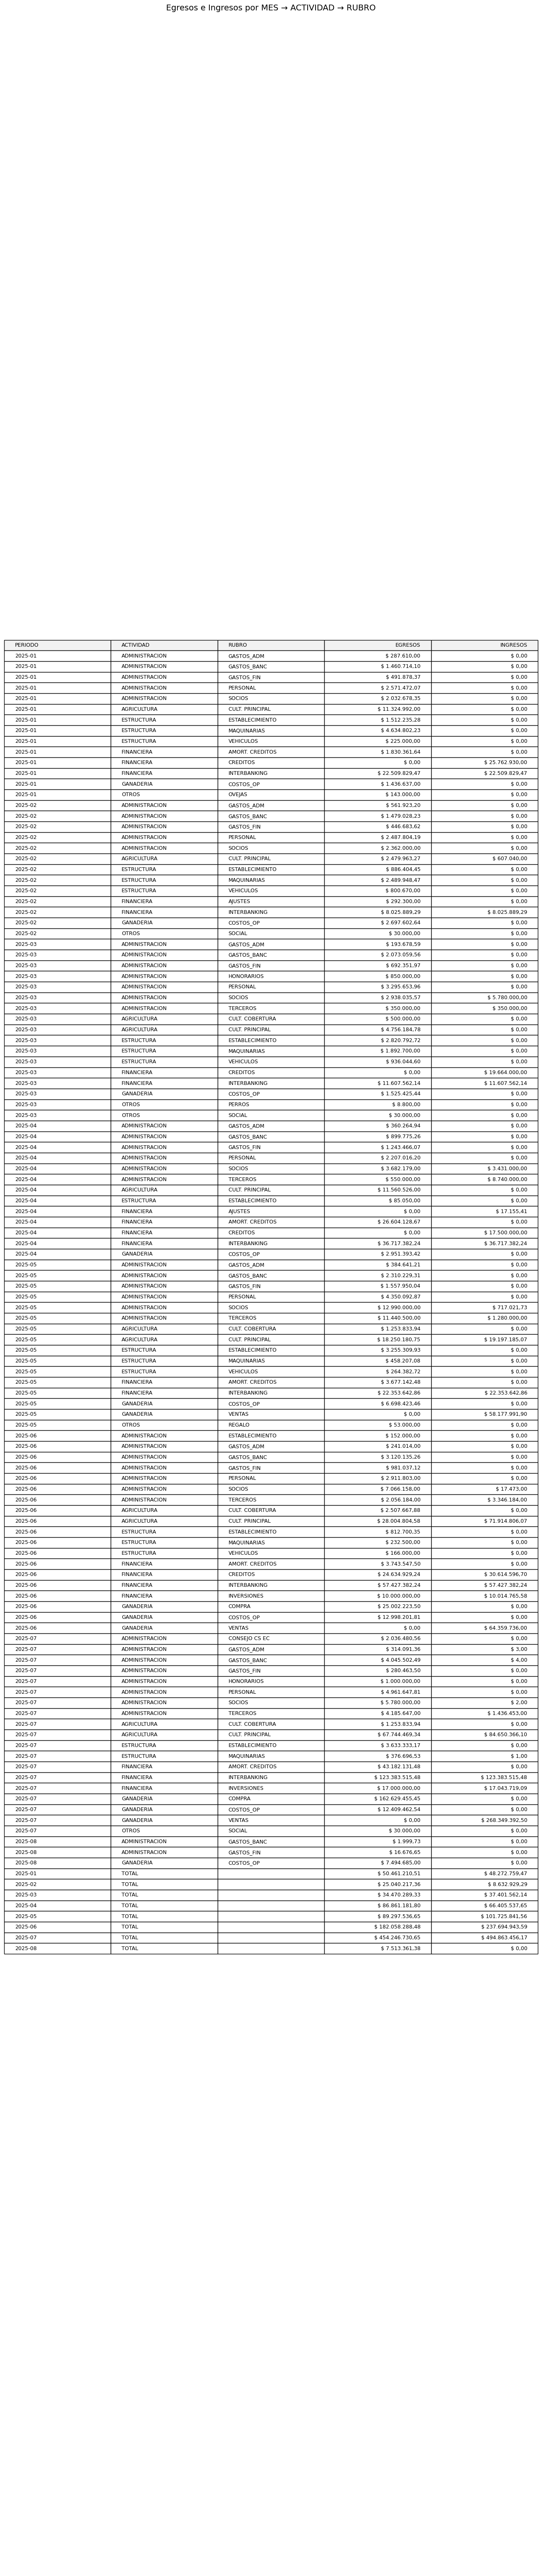

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# === FECHA Y PERIODO ===
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['PERIODO'] = df['FECHA'].dt.to_period('M').astype(str)

# === AGRUPAR POR PERIODO, ACTIVIDAD, RUBRO ===
clasif_detalle = df.groupby(['PERIODO', 'ACTIVIDAD', 'RUBRO'])[['EGRESOS', 'INGRESOS']].sum().reset_index()

# === ORDENAR POR PERIODO, ACTIVIDAD ===
clasif_detalle['PERIODO'] = pd.to_datetime(clasif_detalle['PERIODO'], format='%Y-%m')
clasif_detalle = clasif_detalle.sort_values(by=['PERIODO', 'ACTIVIDAD', 'RUBRO'])
clasif_detalle['PERIODO'] = clasif_detalle['PERIODO'].dt.to_period('M').astype(str)

# === CALCULAR TOTALES POR MES ===
totales_mensuales = clasif_detalle.groupby('PERIODO')[['EGRESOS', 'INGRESOS']].sum().reset_index()
totales_mensuales['ACTIVIDAD'] = 'TOTAL'
totales_mensuales['RUBRO'] = ''

# Reordenar columnas para unir con clasif_detalle
totales_mensuales = totales_mensuales[['PERIODO', 'ACTIVIDAD', 'RUBRO', 'EGRESOS', 'INGRESOS']]

# === UNIR DETALLE + TOTALES ===
clasif_detalle = pd.concat([clasif_detalle, totales_mensuales], ignore_index=True)

# === FORMATEO DE MONTOS ===
def formatear_col(val):
    return f"$ {val:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

clasif_detalle['EGRESOS'] = clasif_detalle['EGRESOS'].apply(formatear_col)
clasif_detalle['INGRESOS'] = clasif_detalle['INGRESOS'].apply(formatear_col)

# === VISUALIZACIÓN EN TABLA ===
fig, ax = plt.subplots(figsize=(13, 0.5 * len(clasif_detalle) + 1))
ax.axis('off')

tabla = ax.table(
    cellText=clasif_detalle.values,
    colLabels=clasif_detalle.columns,
    cellLoc='left',
    loc='center',
    colColours=["#f2f2f2"] * len(clasif_detalle.columns)
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(9)
tabla.scale(1.2, 1.2)

# Alineación por tipo de columna
columnas = clasif_detalle.columns.tolist()
for i, col in enumerate(columnas):
    for j in range(len(clasif_detalle) + 1):
        cell = tabla[j, i]
        if col in ['EGRESOS', 'INGRESOS']:
            cell.get_text().set_ha('right')
        else:
            cell.get_text().set_ha('left')

plt.title("Egresos e Ingresos por MES → ACTIVIDAD → RUBRO", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


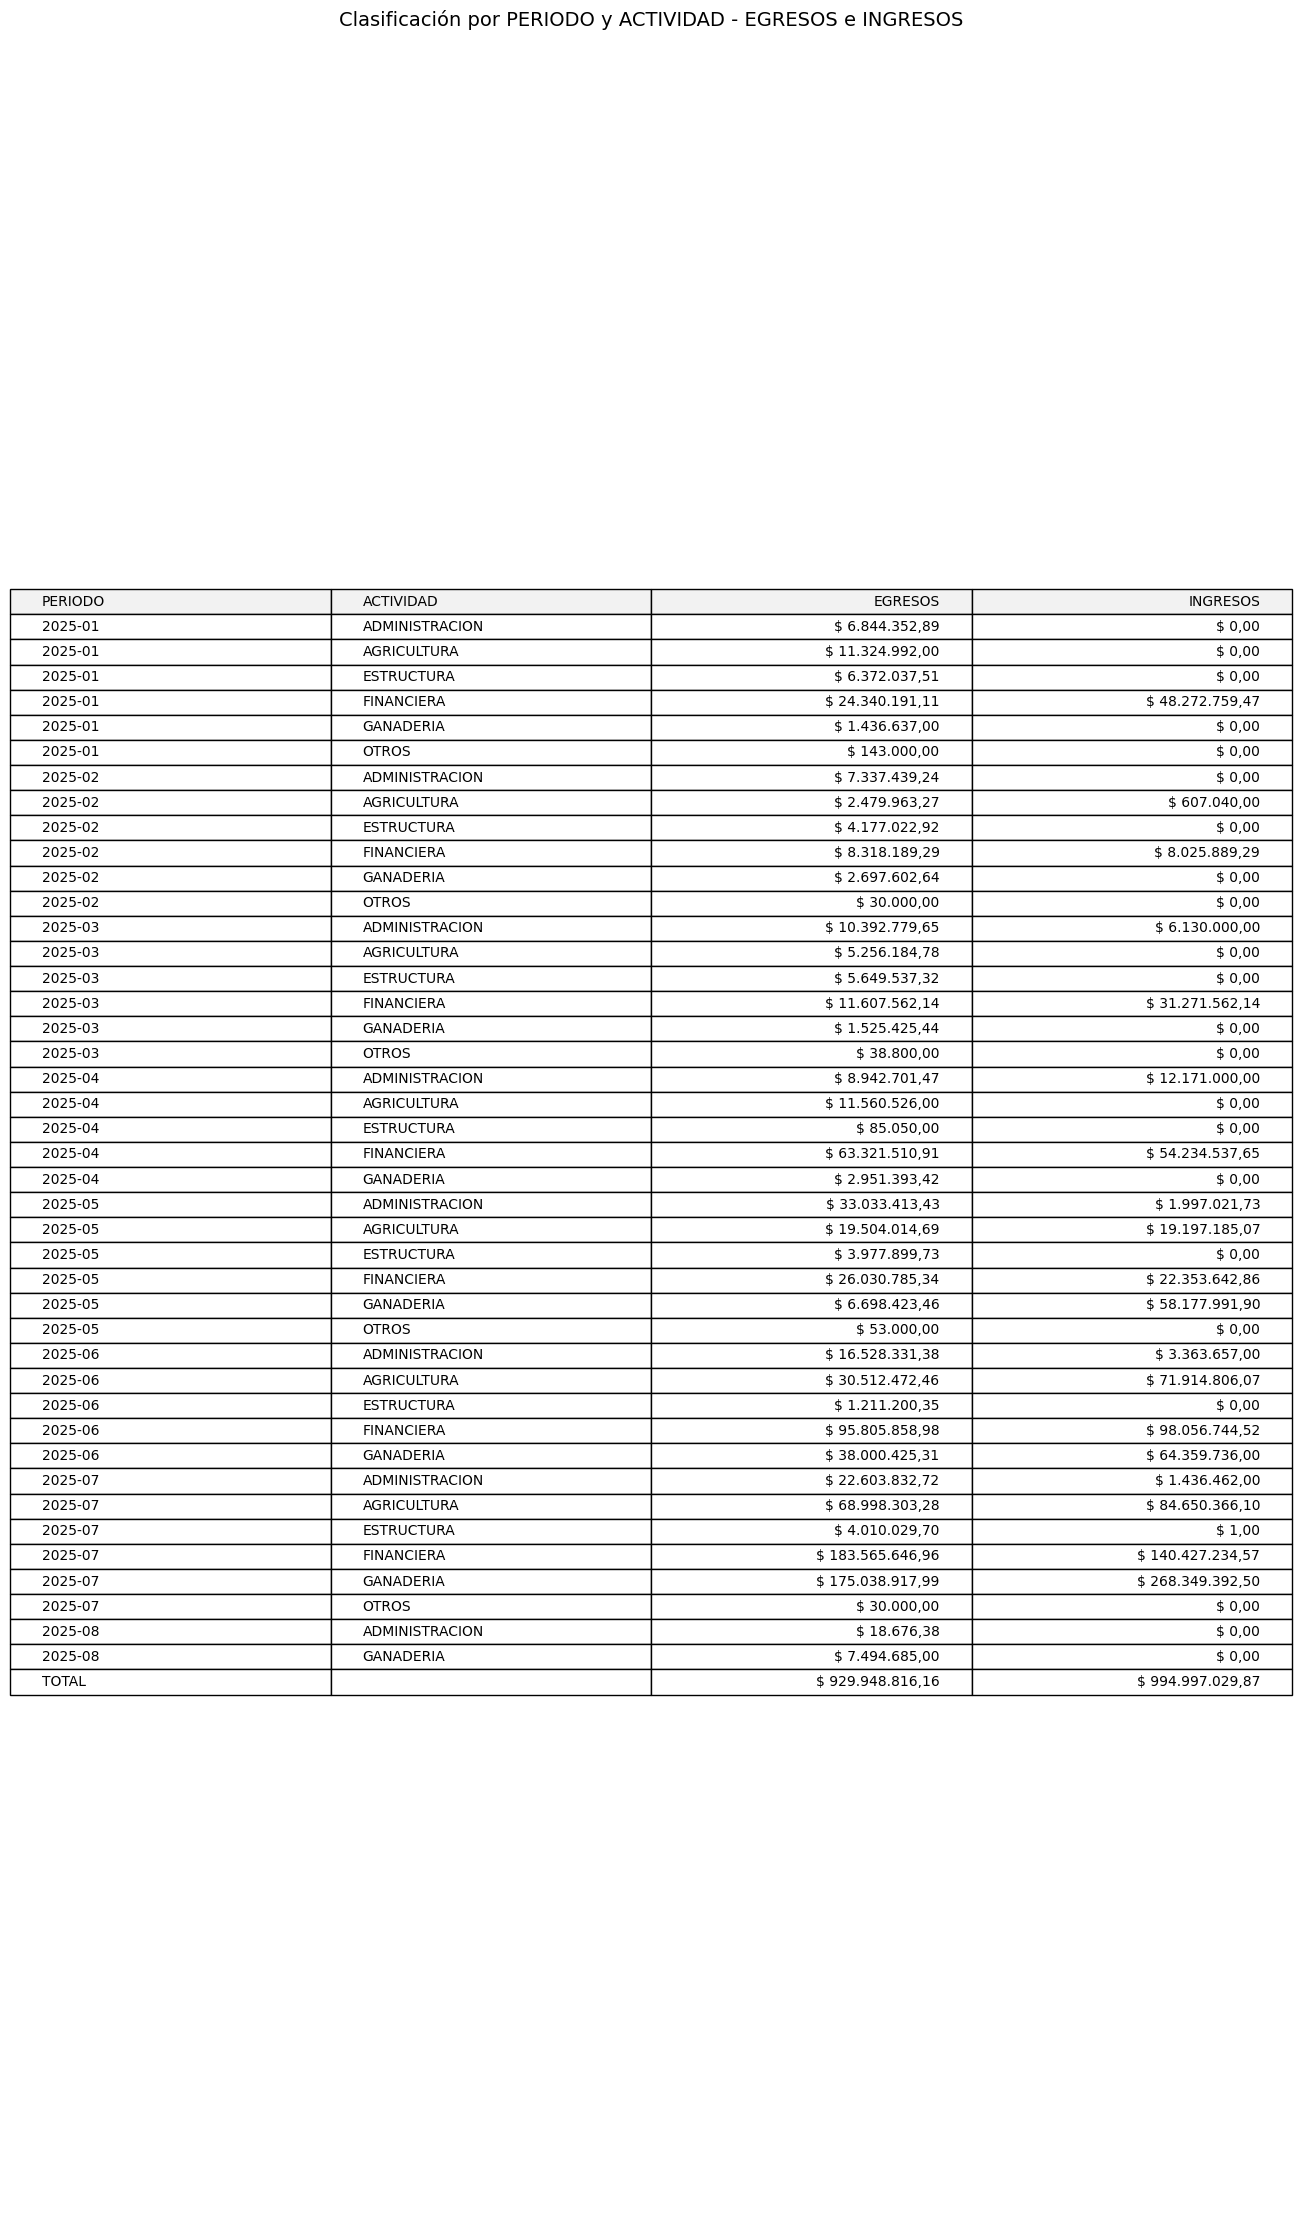

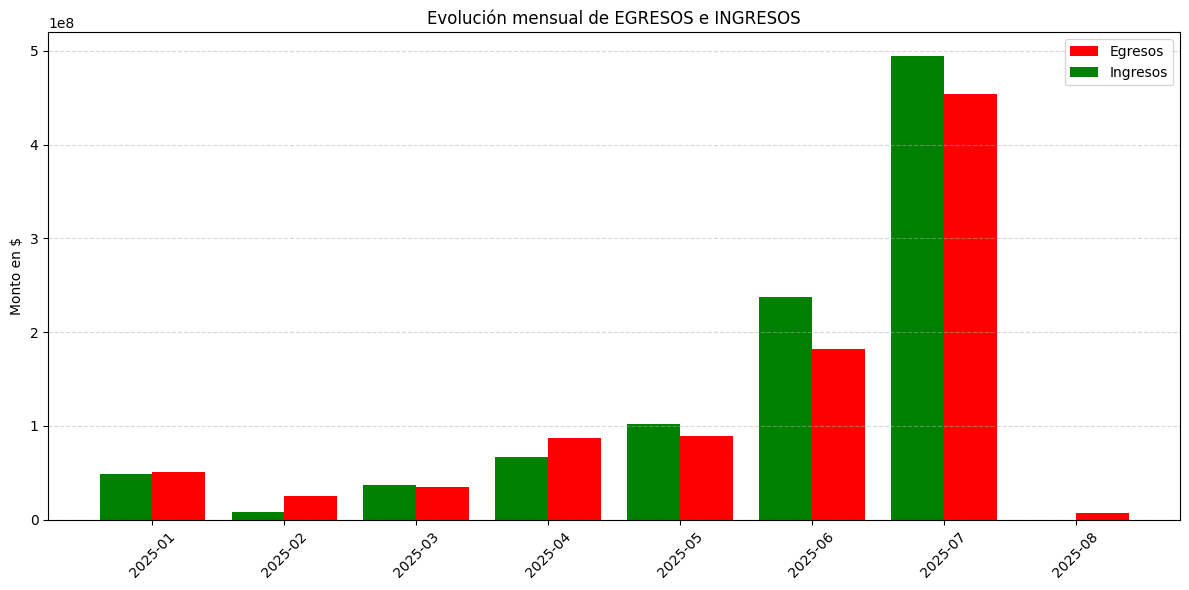

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Aseguramos que FECHA esté en formato datetime y creamos columna PERIODO
df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['PERIODO'] = df['FECHA'].dt.to_period('M').astype(str)

# 2. Agrupamos por PERIODO y ACTIVIDAD
clasificacion = df.groupby(['PERIODO', 'ACTIVIDAD'])[['EGRESOS', 'INGRESOS']].sum().reset_index()

# 3. Ordenamos por PERIODO y ACTIVIDAD
clasificacion['PERIODO'] = pd.to_datetime(clasificacion['PERIODO'], format='%Y-%m')
clasificacion = clasificacion.sort_values(by=['PERIODO', 'ACTIVIDAD'])
clasificacion['PERIODO'] = clasificacion['PERIODO'].dt.to_period('M').astype(str)

# 4. Calculamos totales por PERIODO
totales_periodo = clasificacion.groupby('PERIODO')[['EGRESOS', 'INGRESOS']].sum().reset_index()

# 5. Tabla con totales finales
total_egresos = clasificacion['EGRESOS'].replace('[\$,]', '', regex=True).astype(float).sum()
total_ingresos = clasificacion['INGRESOS'].replace('[\$,]', '', regex=True).astype(float).sum()

def formatear_columna(val):
    return f"$ {val:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

clasificacion['EGRESOS'] = clasificacion['EGRESOS'].astype(float).apply(formatear_columna)
clasificacion['INGRESOS'] = clasificacion['INGRESOS'].astype(float).apply(formatear_columna)

fila_total = pd.DataFrame({
    'PERIODO': ['TOTAL'],
    'ACTIVIDAD': [''],
    'EGRESOS': [formatear_columna(total_egresos)],
    'INGRESOS': [formatear_columna(total_ingresos)]
})

clasificacion_con_total = pd.concat([clasificacion, fila_total], ignore_index=True)

# === TABLA ===
fig, ax = plt.subplots(figsize=(13, 0.5 * len(clasificacion_con_total) + 1))
ax.axis('off')

tabla = ax.table(
    cellText=clasificacion_con_total.values,
    colLabels=clasificacion_con_total.columns,
    cellLoc='left',
    loc='center',
    colColours=["#f2f2f2"] * len(clasificacion_con_total.columns)
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.2)

columnas = clasificacion_con_total.columns.tolist()
for i, col in enumerate(columnas):
    for j in range(len(clasificacion_con_total) + 1):
        cell = tabla[j, i]
        if col in ['EGRESOS', 'INGRESOS']:
            cell.get_text().set_ha('right')
        else:
            cell.get_text().set_ha('left')

plt.title('Clasificación por PERIODO y ACTIVIDAD - EGRESOS e INGRESOS', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# === GRÁFICO DE BARRAS ===
plt.figure(figsize=(12, 6))
x = totales_periodo['PERIODO']
plt.bar(x, totales_periodo['EGRESOS'], width=0.4, label='Egresos', color='red', align='edge')
plt.bar(x, totales_periodo['INGRESOS'], width=-0.4, label='Ingresos', color='green', align='edge')

plt.xticks(rotation=45)
plt.ylabel("Monto en $")
plt.title("Evolución mensual de EGRESOS e INGRESOS")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


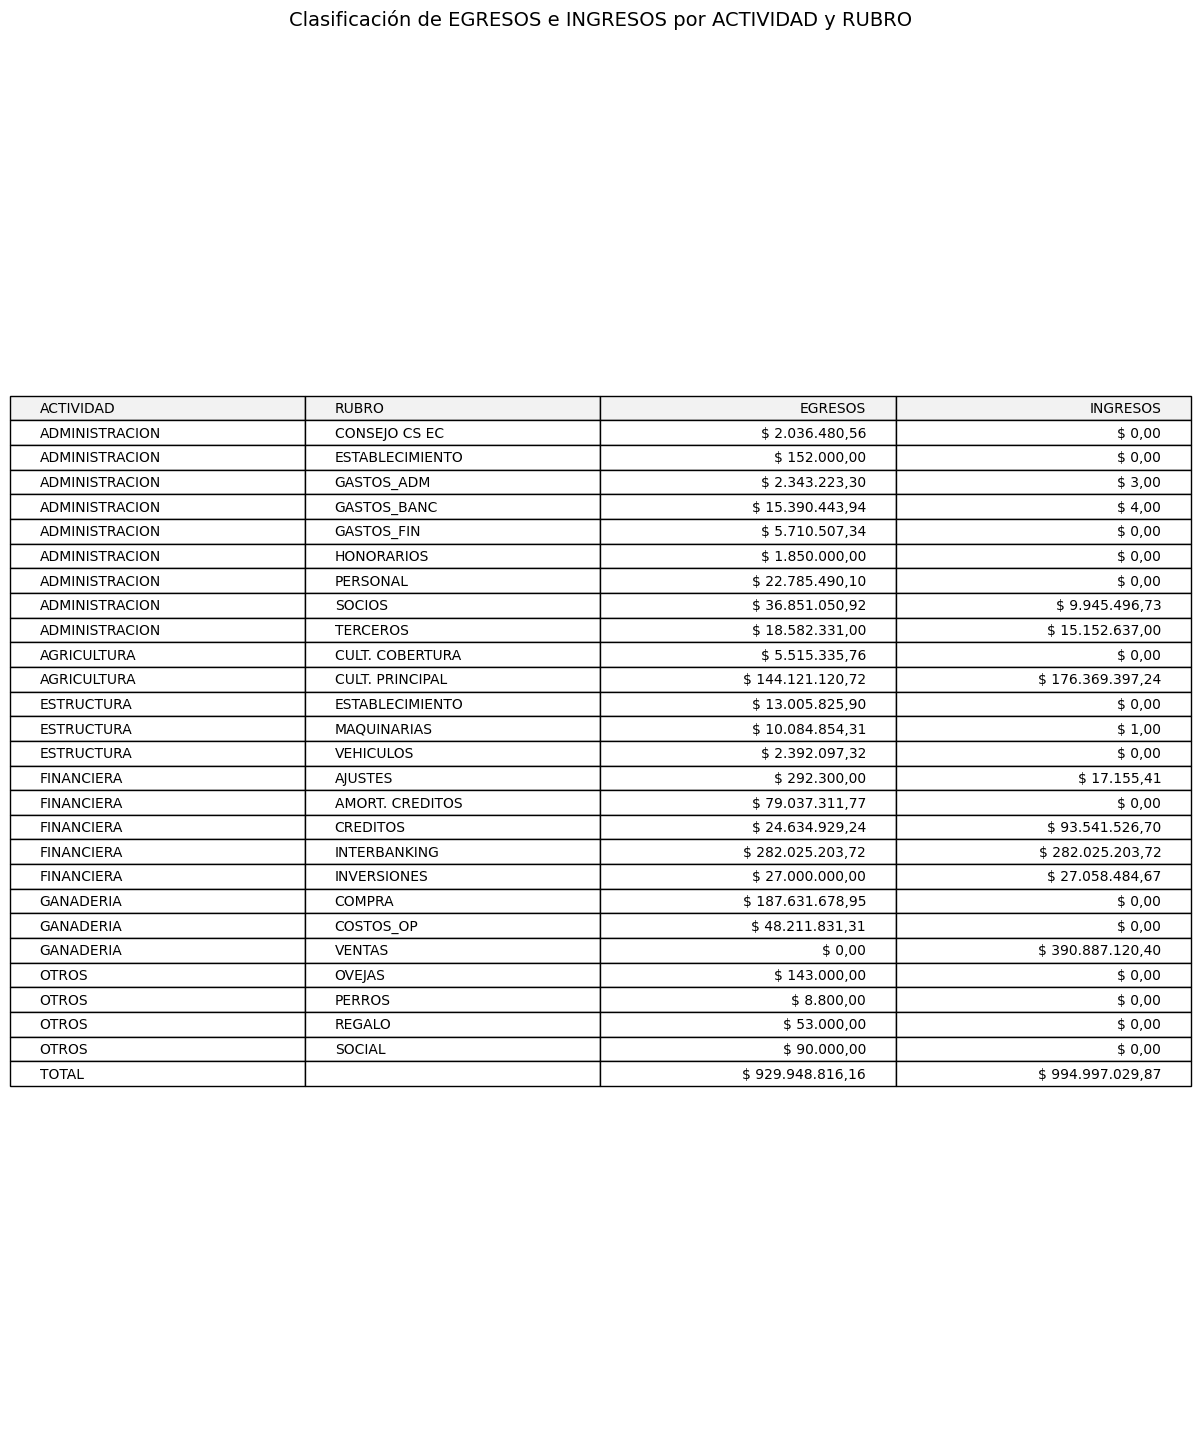

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Agrupamos con df, que tiene los valores numéricos
clasificacion = df.groupby(['ACTIVIDAD', 'RUBRO'])[['EGRESOS', 'INGRESOS']].sum().reset_index()

# 2. Calculamos los totales numéricos antes de formatear
total_egresos = clasificacion['EGRESOS'].sum()
total_ingresos = clasificacion['INGRESOS'].sum()

# 3. Función para formatear números
def formatear_columna(val):
    return f"$ {val:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

# 4. Formateamos las columnas numéricas
clasificacion['EGRESOS'] = clasificacion['EGRESOS'].apply(formatear_columna)
clasificacion['INGRESOS'] = clasificacion['INGRESOS'].apply(formatear_columna)

# 5. Creamos la fila de totales formateada
fila_total = pd.DataFrame({
    'ACTIVIDAD': ['TOTAL'],
    'RUBRO': [''],
    'EGRESOS': [formatear_columna(total_egresos)],
    'INGRESOS': [formatear_columna(total_ingresos)]
})

# 6. Concatenamos la fila total al DataFrame
clasificacion_con_total = pd.concat([clasificacion, fila_total], ignore_index=True)

# 7. Dibujar tabla
fig, ax = plt.subplots(figsize=(12, 0.5 * len(clasificacion_con_total) + 1))
ax.axis('off')

tabla = ax.table(
    cellText=clasificacion_con_total.values,
    colLabels=clasificacion_con_total.columns,
    cellLoc='left',  # Valor por defecto, luego ajustamos
    loc='center',
    colColours=["#f2f2f2"] * len(clasificacion_con_total.columns)
)

# 8. Ajustar estilo
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.2)

# 9. Alineación por columna
columnas = clasificacion_con_total.columns.tolist()
for (i, col) in enumerate(columnas):
    for j in range(len(clasificacion_con_total) + 1):  # +1 por encabezado
        cell = tabla[j, i]
        if col in ['EGRESOS', 'INGRESOS']:
            cell.get_text().set_ha('right')  # Alinear montos a la derecha
        else:
            cell.get_text().set_ha('left')   # Texto descriptivo a la izquierda


plt.title('Clasificación de EGRESOS e INGRESOS por ACTIVIDAD y RUBRO', fontsize=14, pad=20)
plt.tight_layout()
plt.show()



C:\Users\Kevin\AppData\Local\Temp\ipykernel_10696\774091510.py:28: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_formateada = tabla_completa.applymap(formatear_monto)


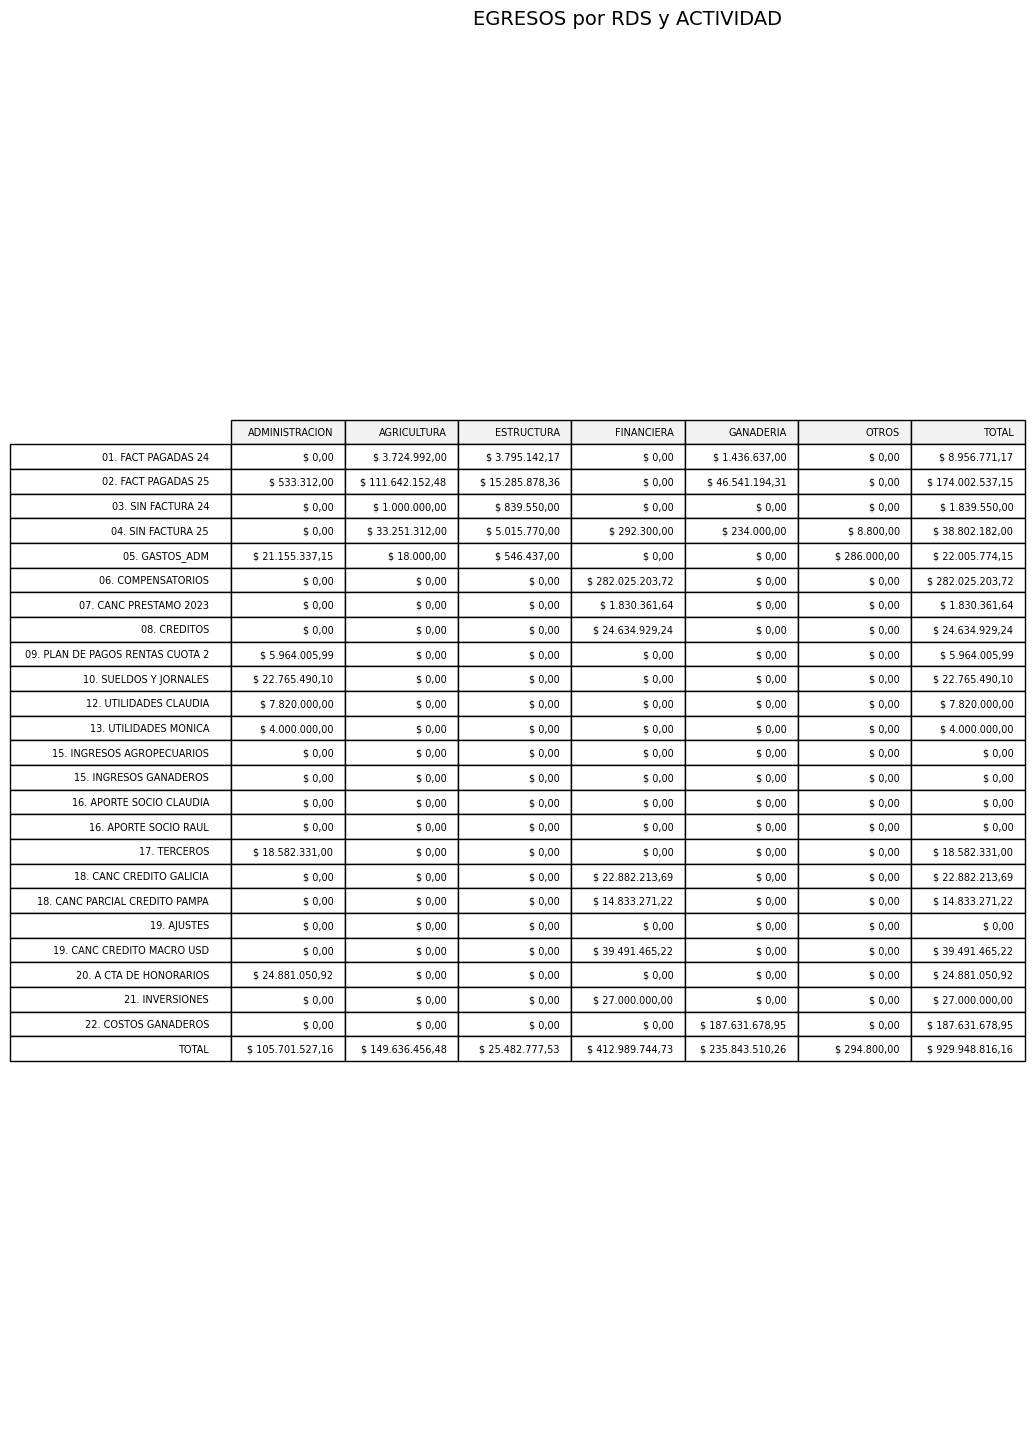

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Asegurar que EGRESOS sea numérico
df['EGRESOS'] = pd.to_numeric(df['EGRESOS'], errors='coerce')

# 2. Crear tabla pivote: RDS como filas, ACTIVIDAD como columnas
tabla_pivote = df.pivot_table(
    index='RDS',
    columns='ACTIVIDAD',
    values='EGRESOS',
    aggfunc='sum',
    fill_value=0
)

# 3. Agregar columna TOTAL
tabla_pivote['TOTAL'] = tabla_pivote.sum(axis=1)

# 4. Agregar fila TOTAL
fila_total = pd.DataFrame(tabla_pivote.sum(axis=0)).T
fila_total.index = ['TOTAL']
tabla_completa = pd.concat([tabla_pivote, fila_total])

# 5. Formatear montos como $ con decimales, . y , al estilo AR
def formatear_monto(val):
    return f"$ {val:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

tabla_formateada = tabla_completa.applymap(formatear_monto)

# 6. Dibujar tabla con Matplotlib
fig, ax = plt.subplots(figsize=(1.7 * len(tabla_formateada.columns), 0.5 * len(tabla_formateada) + 2))
ax.axis('off')

tabla = ax.table(
    cellText=tabla_formateada.values,
    rowLabels=tabla_formateada.index,
    colLabels=tabla_formateada.columns,
    cellLoc='right',
    loc='center',
    colColours=["#f2f2f2"] * len(tabla_formateada.columns)
)

tabla.auto_set_font_size(True)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.2)

# Ajustar alineación
for i in range(len(tabla_formateada.columns)):
    for j in range(len(tabla_formateada) + 1):  # +1 por encabezado
        tabla[j, i].get_text().set_ha('right')  # Montos a la derecha

for j in range(1, len(tabla_formateada) + 1):  # Etiquetas de filas
    tabla[j, -1].get_text().set_ha('right')  # TOTAL a la derecha

plt.title("EGRESOS por RDS y ACTIVIDAD", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [6]:
import pandas as pd

# === 1. Cargar y limpiar los datos ===
def cargar_movimientos_bancarios(filepath):
    df = pd.read_excel(filepath, sheet_name="MOV BANCARIOS 25", skiprows=2)
    df.columns = df.columns.str.strip()

    # Llenar NA en columnas de texto para evitar errores str
    for col_texto in ['RUBRO', 'CONCEPTO']:
        if col_texto in df.columns:
            df[col_texto] = df[col_texto].fillna('')

    # Limpiar formato monetario y convertir a float
    for col in ['EGRESOS', 'INGRESOS']:
        if col in df.columns:
            df[col] = df[col].replace('[\$,]', '', regex=True)
            df[col] = df[col].apply(lambda x: x.replace('.', '').replace(',', '.') if isinstance(x, str) else x)
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
        else:
            df[col] = 0.0

    df['TIPO'] = df.apply(
        lambda row: 'INGRESO' if row['INGRESOS'] > 0 else ('EGRESO' if row['EGRESOS'] > 0 else None),
        axis=1
    )

    df['MONTO'] = df[['INGRESOS', 'EGRESOS']].max(axis=1)

    return df

def armar_flujo_caja(df, mes_filtrado):
    df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
    df = df[df['FECHA'].dt.to_period("M") == mes_filtrado]

    # Evitar error si columnas no existen
    rubro = df['RUBRO'] if 'RUBRO' in df.columns else pd.Series('', index=df.index)

    mask_excluir = rubro.str.lower().str.contains('interbanking', na=False)
    df = df[~mask_excluir]

    ingresos = df[df['TIPO'] == 'INGRESO']
    egresos = df[df['TIPO'] == 'EGRESO']

    resumen = {}

    resumen['INGRESOS'] = ingresos['MONTO'].sum()
    resumen['  INGRESOS OPERATIVOS'] = ingresos[ingresos['RUBRO'].isin(['VENTAS', 'CULT. PRINCIPAL'])]['MONTO'].sum()
    resumen['  INGRESOS NO OPERATIVOS'] = ingresos[ingresos['RUBRO'].isin(['TERCEROS', 'SOCIOS', 'AJUSTES'])]['MONTO'].sum()
    # Créditos detectados en CONCEPTO (recomendado) o en RUBRO (si así están)
    resumen['    CREDITOS'] = ingresos[
    ingresos['RUBRO'].str.upper().str.contains('CREDITO', na=False)
    ]['MONTO'].sum()


    resumen['EGRESOS'] = egresos['MONTO'].sum()
    resumen['  COSTOS OPERATIVOS'] = egresos[egresos['RUBRO'].isin(['PERSONAL', 'AGRICOLA', 'GANADERA'])]['MONTO'].sum()
    resumen['  GASTOS ADMINISTRATIVOS'] = egresos[egresos['RUBRO'].str.upper().str.contains('GASTOS', na=False)]['MONTO'].sum()
    resumen['  GASTOS FINANCIEROS'] = egresos[egresos['CONCEPTO'].str.upper().str.contains('INTERES|COMISION', na=False)]['MONTO'].sum()
    resumen['  OTROS GASTOS'] = egresos[
        ~egresos['RUBRO'].isin(['PERSONAL', 'AGRICOLA', 'GANADERA']) &
        ~egresos['RUBRO'].str.upper().str.contains('GASTOS', na=False)
    ]['MONTO'].sum()

    resumen['RESULTADO OPERATIVO NETO'] = resumen['INGRESOS'] - resumen['EGRESOS']

    return resumen


# === 3. Mostrar como tabla formateada ===
def mostrar_flujo_como_tabla(resumen):
    df_resumen = pd.DataFrame.from_dict(resumen, orient='index', columns=['MONTO'])
    df_resumen.reset_index(inplace=True)
    df_resumen.columns = ['CONCEPTO', 'MONTO']
    
    df_resumen['MONTO'] = df_resumen['MONTO'].apply(
        lambda x: f"$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") if pd.notnull(x) else "-"
    )
    return df_resumen

# === 4. Ejecutar ===
filepath = "4 - MOV BANCARIOS-2025.xlsx"

df = cargar_movimientos_bancarios(filepath)

meses = pd.period_range('2025-01', '2025-12', freq='M')
resumenes = {}

for mes in meses:
    resumenes[str(mes)] = armar_flujo_caja(df, mes)


df_resumen_meses = pd.DataFrame(resumenes).fillna(0)

orden_conceptos = [
    'INGRESOS', '  INGRESOS OPERATIVOS', '  INGRESOS NO OPERATIVOS', '    CREDITOS',
    'EGRESOS', '  COSTOS OPERATIVOS', '  GASTOS ADMINISTRATIVOS', '  GASTOS FINANCIEROS', '  OTROS GASTOS',
    'RESULTADO OPERATIVO NETO'
]
df_resumen_meses = df_resumen_meses.reindex(orden_conceptos)

def formatear_moneda(x):
    return f"$ {x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")

df_resumen_meses_formateado = df_resumen_meses.astype(float).stack().map(formatear_moneda).unstack()


print(df_resumen_meses_formateado.to_string())



                                  2025-01           2025-02          2025-03           2025-04          2025-05           2025-06           2025-07          2025-08 2025-09 2025-10 2025-11 2025-12
INGRESOS                  $ 25.762.930,00      $ 607.040,00  $ 25.794.000,00   $ 29.688.155,41  $ 79.372.198,70  $ 180.267.561,35  $ 371.862.862,79           $ 0,00  $ 0,00  $ 0,00  $ 0,00  $ 0,00
  INGRESOS OPERATIVOS              $ 0,00      $ 607.040,00           $ 0,00            $ 0,00  $ 77.375.176,97  $ 136.274.542,07  $ 352.999.758,60           $ 0,00  $ 0,00  $ 0,00  $ 0,00  $ 0,00
  INGRESOS NO OPERATIVOS           $ 0,00            $ 0,00   $ 6.130.000,00   $ 12.188.155,41   $ 1.997.021,73    $ 3.363.657,00    $ 1.786.453,00           $ 0,00  $ 0,00  $ 0,00  $ 0,00  $ 0,00
    CREDITOS              $ 25.762.930,00            $ 0,00  $ 19.664.000,00   $ 17.500.000,00           $ 0,00   $ 30.614.596,70            $ 0,00           $ 0,00  $ 0,00  $ 0,00  $ 0,00  $ 0,00
EGRESOS        